<a href="https://colab.research.google.com/github/shivani983/computer-vision-handson/blob/main/Weed_crop_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!nvidia-smi

Sat Apr 19 17:39:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# cloning yolo v5
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17410, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 17410 (delta 63), reused 22 (delta 22), pack-reused 17320 (from 3)
Receiving objects: 100% (17410/17410), 16.29 MiB | 16.86 MiB/s, done.
Resolving deltas: 100% (11926/11926), done.


In [44]:
import os
os.chdir("/content/yolov5")

In [45]:
%ls

benchmarks.py    data/       LICENSE         README.md         segment/        val.py
CITATION.cff     detect.py   models/         README.zh-CN.md   train.py
classify/        export.py   __pycache__/    requirements.txt  tutorial.ipynb
CONTRIBUTING.md  hubconf.py  pyproject.toml  runs/             utils/


In [28]:
# installing requirements
!pip install -r requirements.txt
import torch

from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.5.1+cu124 (Tesla T4)


In [29]:
%pwd

'/content/yolov5'

In [46]:
%cd ..

/content


In [47]:
!unzip /content/drive/MyDrive/computervision/weed_crop.zip

Streaming output truncated to the last 5000 lines.
  inflating: WeedCrop.v1i.yolov5pytorch/train/images/32332_jpg.rf.2376e7d1a0cd8cf89656c6b4857790af.jpg  
  inflating: WeedCrop.v1i.yolov5pytorch/train/images/32332_jpg.rf.91e08632ff45cce92000c70db0fc553f.jpg  
  inflating: WeedCrop.v1i.yolov5pytorch/train/images/32332_jpg.rf.c6a239f8407836211e5c857160d1f4e6.jpg  
  inflating: WeedCrop.v1i.yolov5pytorch/train/images/32334_jpg.rf.11b5fff5519a8791e281d25926ca3ebb.jpg  
  inflating: WeedCrop.v1i.yolov5pytorch/train/images/32334_jpg.rf.28a92af8634ea7c9b98f895335f0473f.jpg  
  inflating: WeedCrop.v1i.yolov5pytorch/train/images/32334_jpg.rf.9ce44a0bbd289bb979511458f1a2b84a.jpg  
  inflating: WeedCrop.v1i.yolov5pytorch/train/images/32335_jpg.rf.50b74e422265273b9446ddd551647a7f.jpg  
  inflating: WeedCrop.v1i.yolov5pytorch/train/images/32335_jpg.rf.6b293fd984a06c6e72b5f55e17208149.jpg  
  inflating: WeedCrop.v1i.yolov5pytorch/train/images/32335_jpg.rf.89e8f04ef19f3829973bc05579fdd144.jpg  
  in

In [50]:
%cat /content/yolov5/models/yolov5s.yaml

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 

In [51]:
# customizing iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))



In [52]:
num_classes = 2

yaml_content = f"""
# Parameters

nc: {num_classes}  # number of classes
depth_multiple: 0.33
width_multiple: 0.50
anchors:
  - [10, 13, 16, 30, 33, 23]    # P3/8
  - [30, 61, 62, 45, 59, 119]   # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  [
    [-1, 1, Conv, [64, 6, 2, 2]],
    [-1, 1, Conv, [128, 3, 2]],
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]],
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]],
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]],
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]],
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]],
    [-1, 3, C3, [512, False]],

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]],
    [-1, 3, C3, [256, False]],

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]],
    [-1, 3, C3, [512, False]],

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]],
    [-1, 3, C3, [1024, False]],

    [[17, 20, 23], 1, Detect, [{num_classes}, anchors]],  # Correct variable usage here
]
"""

with open("/content/yolov5/models/custom_yolov5s.yaml", "w") as f:
    f.write(yaml_content)


In [53]:
%pwd

'/content/yolov5'

In [54]:
cd ..

/content


In [55]:
!mv WeedCrop.v1i.yolov5pytorch yolov5/


In [56]:
# !echo "train: /content/yolov5/SkyFusion/train/images" > /content/yolov5/data.yaml
# !echo "val: /content/yolov5/SkyFusion/valid/images" >> /content/yolov5/data.yaml
# !echo "nc: 3" >> /content/yolov5/data.yaml
# !echo "names: ['Aircraft', 'ship', 'vehicle']" >> /content/yolov5/data.yaml


In [57]:
!echo "train: /content/yolov5/WeedCrop.v1i.yolov5pytorch/train/images" > /content/yolov5/data.yaml
!echo "val: /content/yolov5/WeedCrop.v1i.yolov5pytorch/valid/images" >> /content/yolov5/data.yaml
!echo "nc: 2" >> /content/yolov5/data.yaml
!echo "names: ['crop', 'weed']" >> /content/yolov5/data.yaml


In [58]:
%pwd

'/content'

In [61]:
# training yolov5

%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 30 --data '/content/yolov5/data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results --cache

Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
      14/29      1.84G    0.06129    0.02145   0.002543        213        416:  17% 27/155 [00:04<00:18,  6.90it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      14/29      1.84G    0.06119    0.02131   0.002526        110        416:  18% 28/155 [00:04<00:18,  7.03it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      14/29      1.84G    0.06126    0.02139   0.002477        178        416:  19% 29/155 [00:04<00:17,  7.22it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp

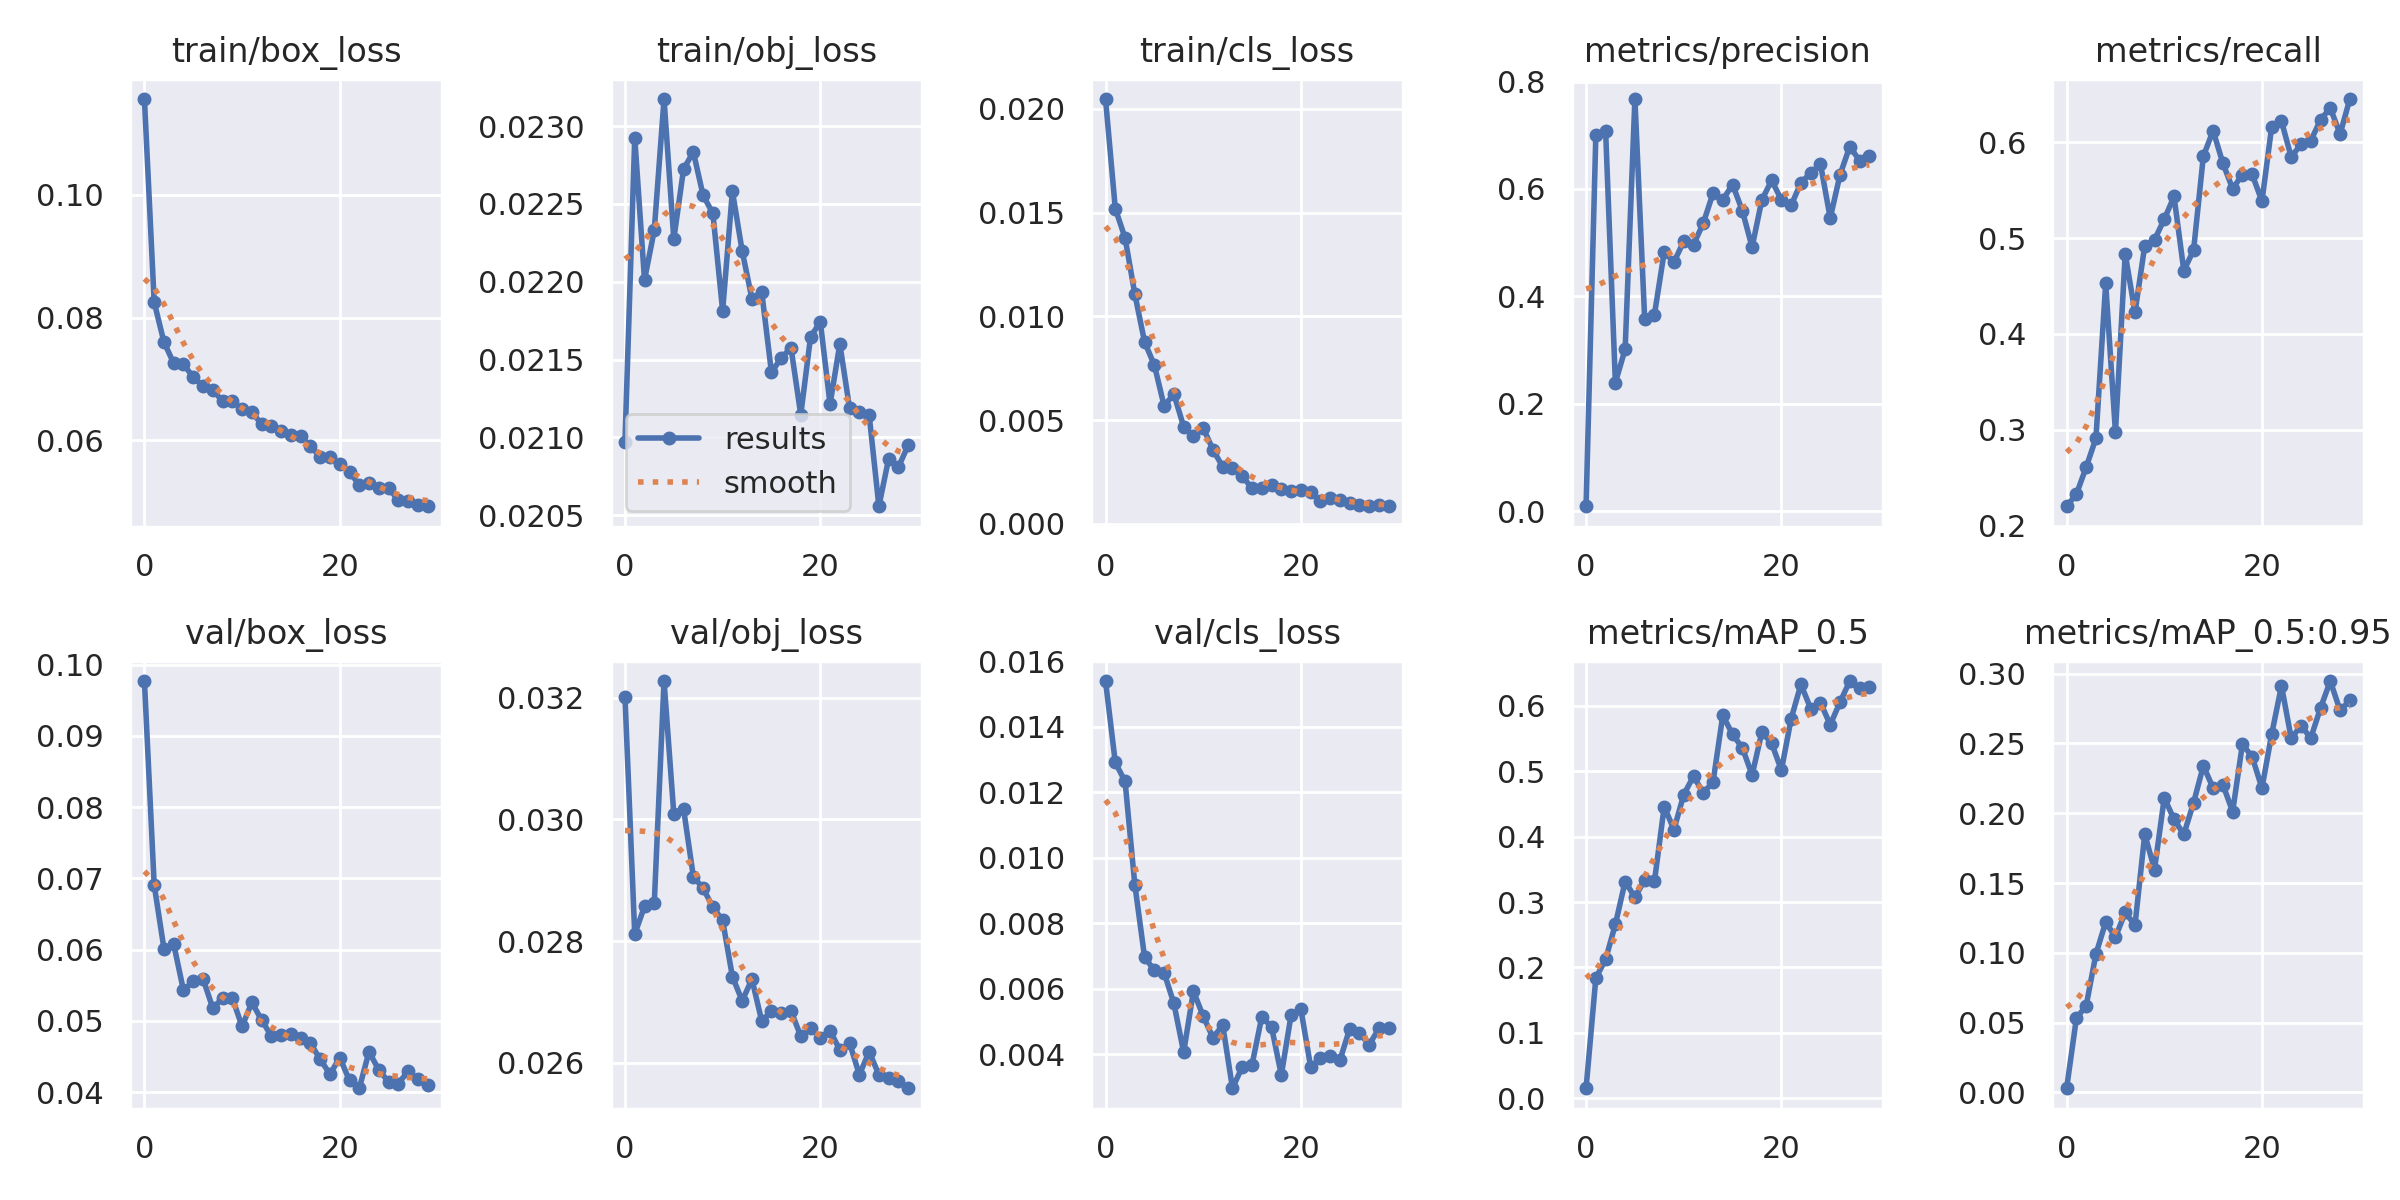

In [63]:
# evaluating the model
import utils
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results8/results.png')

augmented trainig data


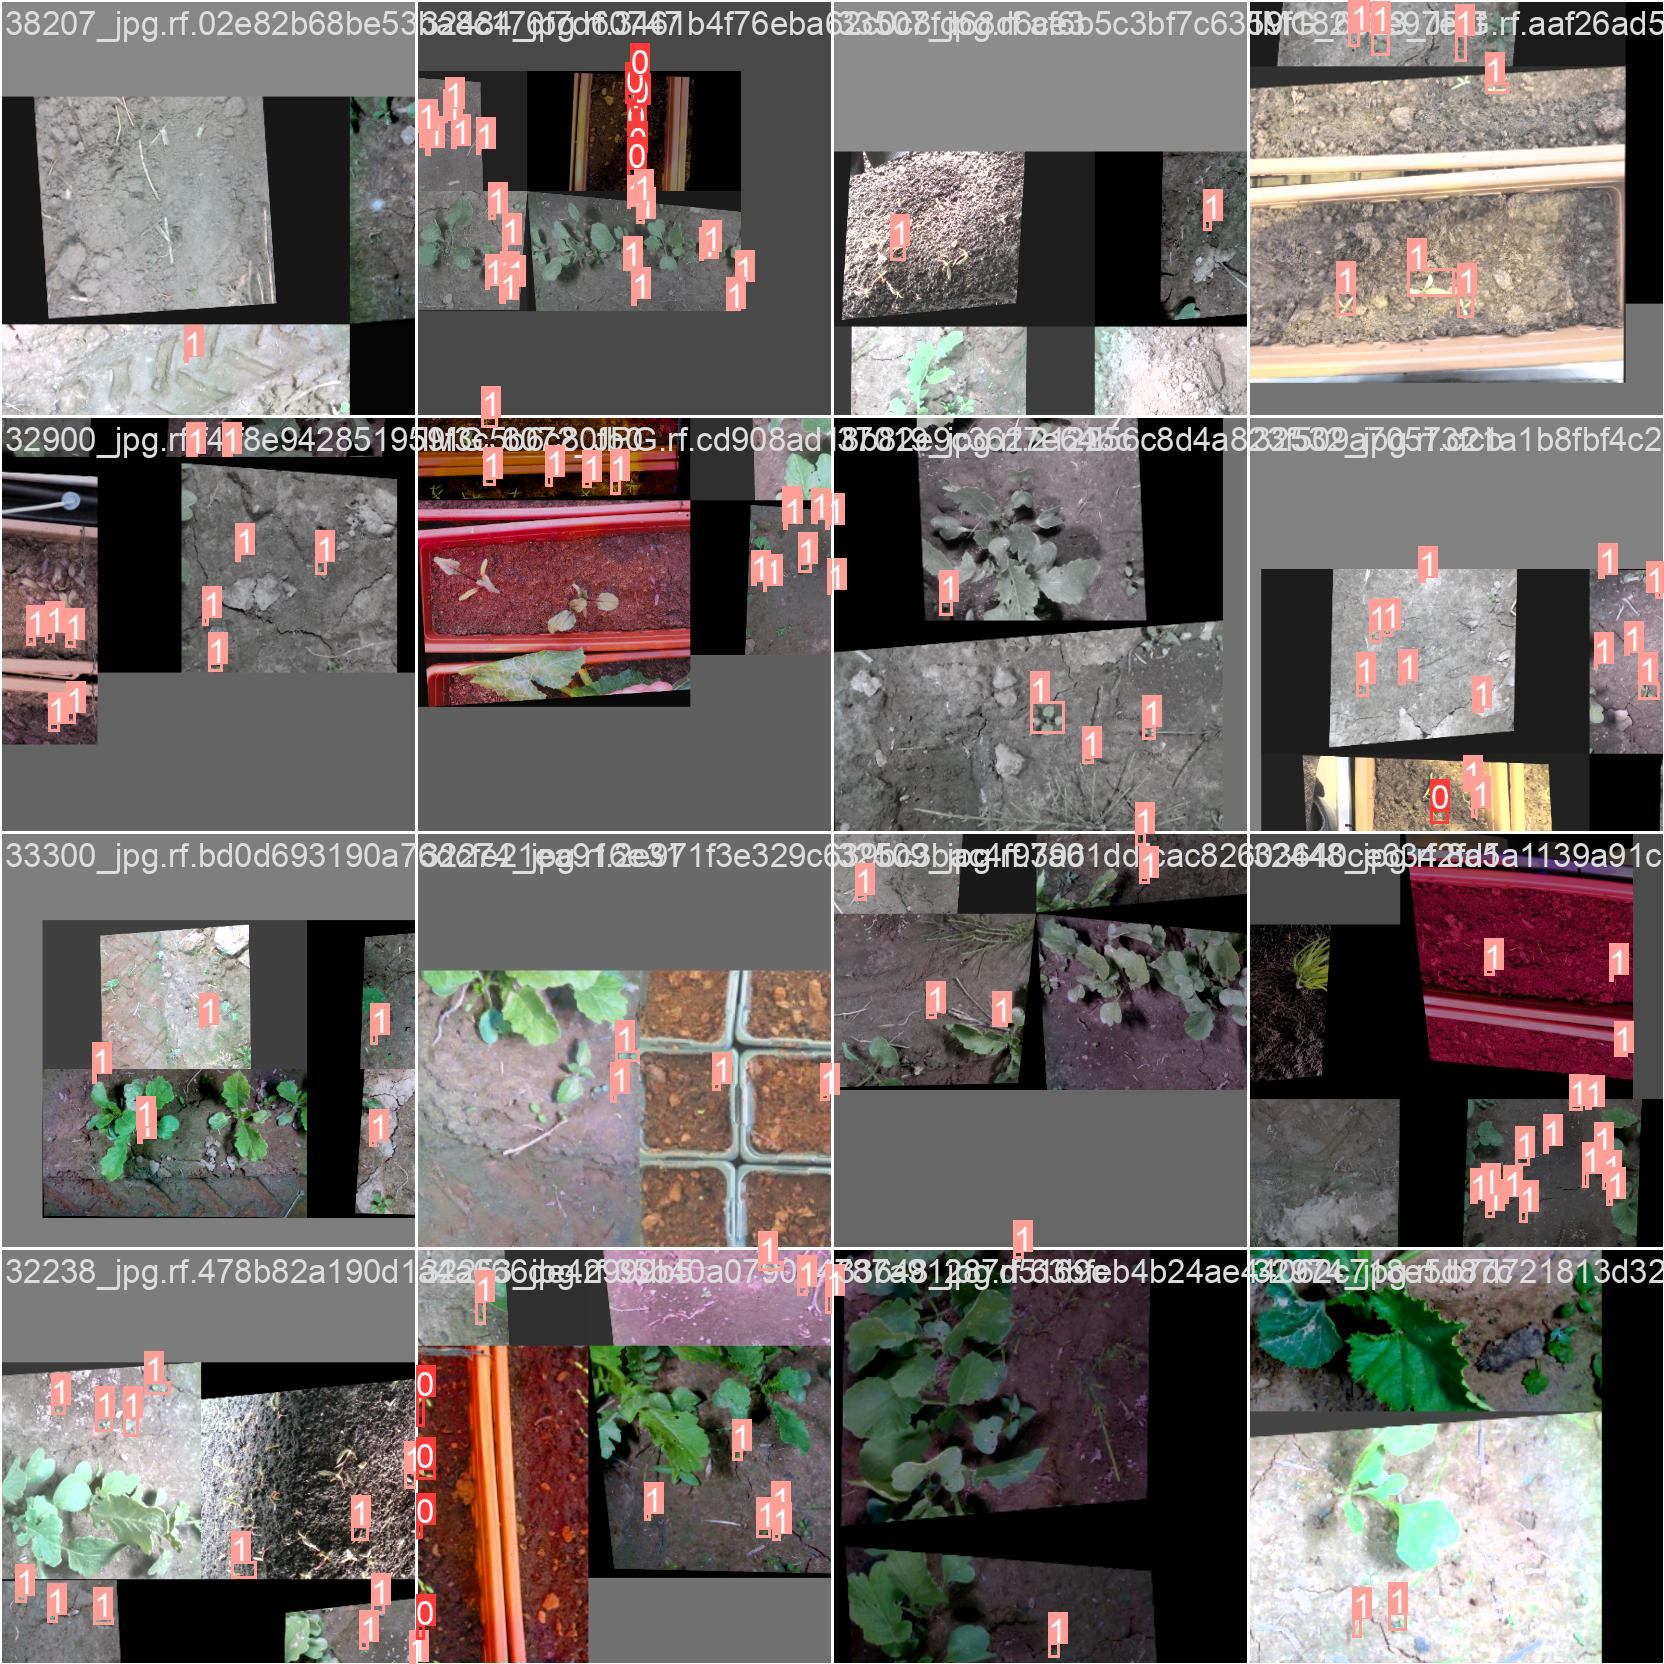

In [64]:
#printing images
print("augmented trainig data")
Image(filename = '/content/yolov5/runs/train/yolov5s_results8/train_batch0.jpg', width=1000)